In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [17]:
import torch
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim))

In [18]:
x.shape

torch.Size([1, 4, 512])

In [19]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [20]:
qkv = qkv_layer(x)

In [21]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'Histogram of qkv')

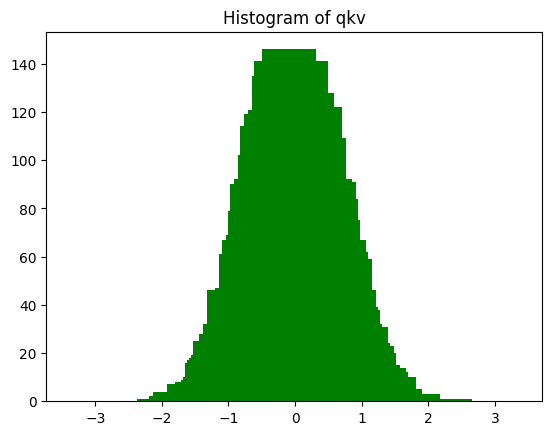

In [22]:
import matplotlib.pyplot as plt
from sympy.abc import y

y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01)*3
plt.bar(x_val, y_val, align='center', color='g')
plt.title('Histogram of qkv')

In [23]:
num_heads = 8
head_dim = d_model//num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3*head_dim)

In [24]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [25]:
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [27]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [28]:
import math
import torch
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [29]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [33]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][0]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [34]:
(scaled + mask)[0][0]

tensor([[-0.3773,    -inf,    -inf,    -inf],
        [ 0.5959,  0.4165,    -inf,    -inf],
        [-0.7496,  0.6192,  0.2949,    -inf],
        [-0.2791,  0.1175, -0.0230, -0.0103]], grad_fn=<SelectBackward0>)

In [35]:
scaled += mask

In [38]:
attention = F.softmax(scaled, dim=-1)
attention.shape

torch.Size([1, 8, 4, 4])

In [40]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [41]:
import math

def scaled_dot_product(q, k, v, mask = None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim = -1)
    values = torch.matmul(attention, v)

    return values, attention

In [47]:
values, attention = scaled_dot_product(q, k, v, None)

In [49]:
values.shape, attention[0][0]

(torch.Size([1, 8, 4, 64]),
 tensor([[0.1518, 0.2286, 0.4544, 0.1652],
         [0.3945, 0.3297, 0.1107, 0.1651],
         [0.0716, 0.2812, 0.2033, 0.4439],
         [0.1966, 0.2923, 0.2540, 0.2572]], grad_fn=<SelectBackward0>))

## concatenate the heads

In [50]:
values = values.reshape(batch_size, sequence_length, num_heads*head_dim)
values.shape

torch.Size([1, 4, 512])

## just so the heads can communicate with each other, we use a linear layer

In [51]:
linear = nn.Linear(d_model, d_model)

In [52]:
out = linear(values)

In [53]:
out.shape

torch.Size([1, 4, 512])

In [56]:
import math
import torch.nn as nn
import torch
import math
import torch.nn as nn
import torch
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim ## embedding size
        self.d_model = d_model  ## attention head embedding size
        assert d_model % num_heads == 0, "d_model should be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_linear = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask = None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(),{x.size()}")
        qkv = self.qkv_linear(x) # (batch_size, seq_len, 3 * d_model)
        print(f"qkv.size(),{qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3*self.head_dim)
        print(f"qkv.size(), {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3) # (batch_size, num_heads, seq_len, head_dim)
        print(f"qkv.size(), {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q.size(), {q.size()}", f"k.size(), {k.size()}", f"v.size(), {v.size()}")
        values, attention_weights = scaled_dot_product(q, k, v, mask)
        print(f"values.size(), {values.size()}", f"attention_weights.size(), {attention_weights.size()}")
        values = values.reshape(batch_size, sequence_length, self.d_model)
        print(f"values.size(), {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(), {out.size()}")
        return out



In [57]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(),torch.Size([30, 5, 1024])
qkv.size(),torch.Size([30, 5, 1536])
qkv.size(), torch.Size([30, 5, 8, 192])
qkv.size(), torch.Size([30, 8, 5, 192])
q.size(), torch.Size([30, 8, 5, 64]) k.size(), torch.Size([30, 8, 5, 64]) v.size(), torch.Size([30, 8, 5, 64])
values.size(), torch.Size([30, 8, 5, 64]) attention_weights.size(), torch.Size([30, 8, 5, 5])
values.size(), torch.Size([30, 5, 512])
out.size(), torch.Size([30, 5, 512])
